### Spring 2020 - Knowledge Discovery in Data at Scale Technologies - Homework #3
by Almaz Murzabekov

## Homework description

### Linear Regression

Write a program which illustrates simple linear regression (or a more general variant of linear regression) and implements accumulation of canonical information.

**a)** For some fixed parameters $a$ and $b$ (or, in a more general case, $a1$, . . . , $am$) generate a sequence of *observations* $(xi, yi)$:

$$y_i = f(x_i)+ε_i,$$

where

$$f(x)=a+bx$$  or  $$f(x)=a_1+a_2x+a_3x^2+···+a_mx^{(m−1)}$$

$ε_i$ are i.i.d. with zero mean and $Eεi = σ$ . Values $x_i$ can be generated randomly with some mean and variance.

**b)** Accumulate canonical information, i.e.,at each step, when a new observation $(x_i,y_i)$ is produced, update canonical information

**c)** Illustrate the real function $f (x)$ and its estimate $\widehat{f (x)}.$

**d)** Illustrate $Var(\widehat{f(x))}$, assuming that $σ^2$ is known.

**e)** Illustrate $\widehat{Var(\widehat{f (x)})}$, assuming that $σ^2$ is NOT known.

In your report present the source code and a few (around 3) nice graphs showing estimations for *“small”*, *“intermediate”*, and *“large”* number of observations.

## God damn! How to solve it?

### Relax, don't panic!

Function used in the demo - polynomial:

$$y_i =1+1·x_i−1·x_i^2+0.2·x_i^3+ε_i$$

Data: $$(x_i, y_i), i = 1,...,n$$

Canonical information: $$(T, v, V, n)$$

Elementary information: $$(T_i, v_i, V_i, n_i)$$

Update:
$$(T, v, V, n) + (T_i, v_i, V_i, n_i) = (T + T_i, v + v_i, V + V_i, n + n_i)$$

Estimate $f(x):$

$$(T, v, V, n) ∗ x => $$
    
$$\widehat{f(x)} = F_xT^{-1}v$$
    
$$Var(\widehat{f(x)}) = σ^2F_xT^{-1}F_x^{T}$$

$$\widehat{Var(\widehat{f(x)})} = {\frac{V−v^TT^{−1}v}{n-m}}*F_xT^{-1}F_x^{T}$$

### Now, as you see it becomes simple! Just define the functions and plot three pictures?!

Ok, but I don't got it! What is the $T$,$v$,$V$,and $n$?

Hmm... Let's look at the HW paper?!

$$n_i = 1,$$ 


$$V_i = y_i^2,$$

$$v = F^{T}_{x_i} · y_i = \begin{pmatrix}
  f_1(x_i)y_i\\
  \vdots \\
  f_4(x_i)y_i\\
 \end{pmatrix}$$


$$T_i = F^{T}_{x_i}*F_{x_i} = \begin{pmatrix}
  f_1(x_i)^2 & f_1(x_i)f_2(x_i) & \cdots & f_1(x_i)f_4(x_i) \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  f_4(x_i)f_1(x_i) & f_4(x_i)f_2(x_i) & \cdots & f_4(x_i)^2 \\
 \end{pmatrix}$$

### Oh... it is simple now and I know how to solve the task?! I need just implement four functions that calculates these variables $n, v, V, T$

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
WINDOW_START = 0
WINDOW_END   = 4
WINDOW_STEP  = 0.1

FIGURE_WIDTH = 20
FIGURE_HEIGHT= 10

M_SIZE = 4
A = np.array([1, 1, -1, 0.2])

#### So, let's define the canonical information. I thinks the tuple4 is the best solution, isn't it?

Canonical information in python is a tuple4 $(n, v, V, T)$


In [3]:
def get_initial_cannonical_info(x, y):
    n = 1
    V = y * y
    Fxi = np.array([x ** k for k in range(M_SIZE)])
    v = Fxi * y
    T = np.matmul(np.expand_dims(Fxi, 1), np.expand_dims(Fxi, 1).T)

    return (n, V, v, T)

In [4]:
def update_canonical_info(prev, x, y):
    n_prev, V_prev, v_prev, T_prev = prev
    n_curr, V_curr, v_curr, T_curr = get_initial_cannonical_info(x, y)
    
    n_new = n_prev + n_curr
    V_new = V_prev + V_curr
    v_new = v_prev + v_curr
    T_new = T_prev + T_curr
    
    return (n_new, V_new, v_new, T_new)

### Let's try to draw a right function (red)

In [5]:
def f(x):
    x_p = np.array([x ** k for k in range(M_SIZE)])
    return np.dot(A, x_p)

In [6]:
def draw_right_function(plot):
    x = np.arange(WINDOW_START, WINDOW_END, WINDOW_STEP)

    y = [f(xi) for xi in x]
    
    plot.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    plot.plot(x, y, 'r', label='f_real', linewidth=5)

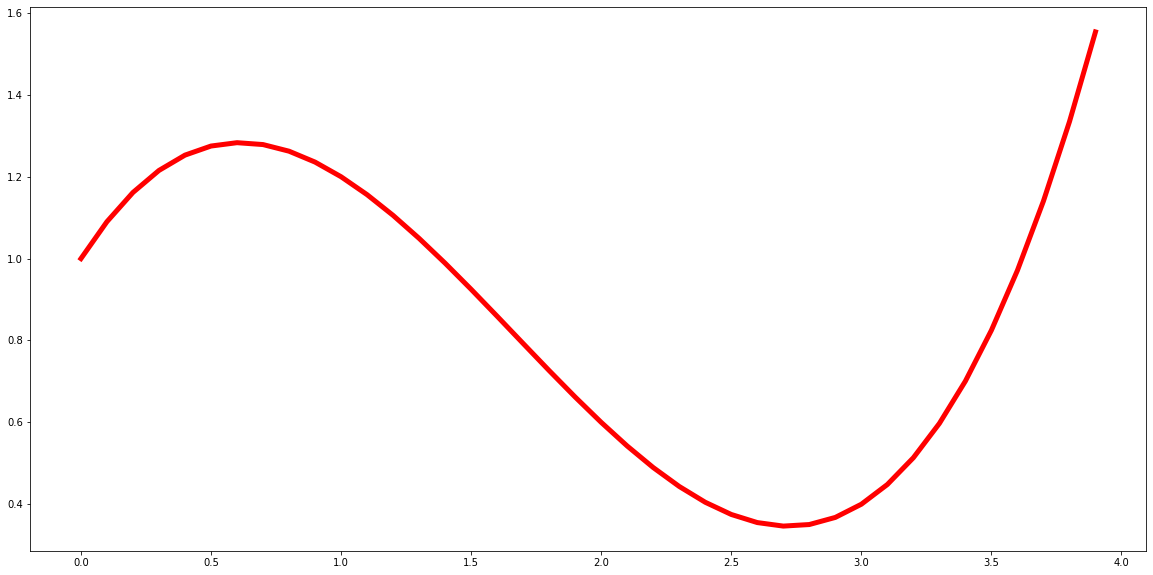

In [7]:
draw_right_function(plt)

### Let's try to define estimate function

In [8]:
def estimate_f(cannonical_info, x_i):
    # 𝑓(𝑥)ˆ=𝐹𝑥𝑇−1𝑣
    n_prev, V_prev, v_prev, T_prev = cannonical_info
    Fx = np.expand_dims(np.array([x_i ** k for k in range(M_SIZE)]), 0)
    T_1 = np.linalg.inv(T_prev)
    v = np.expand_dims(v_prev, 1)
    
    ## Please, don't ask me "What there happening, because I don't know. I found it from stackoverflow"
    return np.squeeze(np.matmul(np.matmul(Fx, T_1), v)).item()

### Good. Next is the variance of the estimate function

In [9]:
def variance_of_estimate_f(cannonical_info, x_i, eps):
    # 𝑉𝑎𝑟(𝑓(𝑥)ˆ)=σ2𝐹𝑥𝑇−1𝐹𝑇𝑥
    
    n_prev, V_prev, v_prev, T_prev = cannonical_info
    Fx = np.expand_dims(np.array([x_i ** k for k in range(M_SIZE)]), 0)
    T_1 = np.linalg.inv(T_prev)
    ## Please, don't ask me "What there happening, because I don't know. I found it from stackoverflow"
    return np.squeeze((eps * np.matmul(np.matmul(Fx, T_1), Fx.T))).item()

### The last is **monstrous** function - Estimation of variance of the estimate functions... God damn!

$$\widehat{Var(\widehat{f(x)})} = {\frac{V−v^TT^{−1}v}{n-m}}*F_xT^{-1}F_x^{T}$$

In [221]:
#𝑉𝑎𝑟(𝑓(𝑥)ˆ)ˆ=(𝑉−𝑣𝑇𝑇−1𝑣/(𝑛−𝑚))∗𝐹𝑥𝑇−1𝐹𝑇𝑥
def my_monstrous_function(cannonical_info, x_i):
    n, V, v, T = cannonical_info   
        
    Fx = np.expand_dims(np.array([x_i ** k for k in range(M_SIZE)]), 0)
    T_1 = np.linalg.inv(T)
    numerator = V - np.matmul(np.matmul(v.T, T_1), v)
    denominator = n - M_SIZE
    
    multiplier = np.matmul(np.matmul(Fx, T_1), Fx.T)
    result = (numerator / denominator) * multiplier
    
    return result.item()

### OK, Let's move on - make a sample with n = 10 and plot all the results

In [256]:
def draw(plot, cannonical_info, observations_x, y, eps):
    right_y = [f(x) for x in observations_x]
    estimated_y = np.array([estimate_f(cannonical_info, x) for x in observations_x])

    var_y = np.array([variance_of_estimate_f(cannonical_info, x, eps) for idx, x in enumerate(observations_x)])
    var_y_plus = estimated_y + var_y
    var_y_minus = estimated_y - var_y
    
    var_var_of_est_y = np.array([my_monstrous_function(cannonical_info, x) for x in observations_x])
    var_var_of_est_y_plus = estimated_y + var_var_of_est_y
    var_var_of_est_y_minus = estimated_y - var_var_of_est_y
    
    
    #print(var_y)
    #print(var_var_of_est_y)
    
    #print(var_var_of_est_y_plus)
    #print(var_y_minus)
    
    #print(x)
    #print(var_var_of_est_y_plus)
        
    plot.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    plot.plot(x, y, 'o', markersize=10)
    plot.plot(x, right_y, 'r', label = "Real", linewidth=5)
    plot.plot(x, estimated_y, 'b', label = "Estimate")
    plot.plot(x, var_y_plus, 'g', label = "Variance of Estimation")
    plot.plot(x, var_y_minus, 'g')
    
    plot.plot(x, var_var_of_est_y_plus, 'y', label = "Variance of variance of Estimation")
    plot.plot(x, var_var_of_est_y_minus, 'y')
    
    plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot.show()


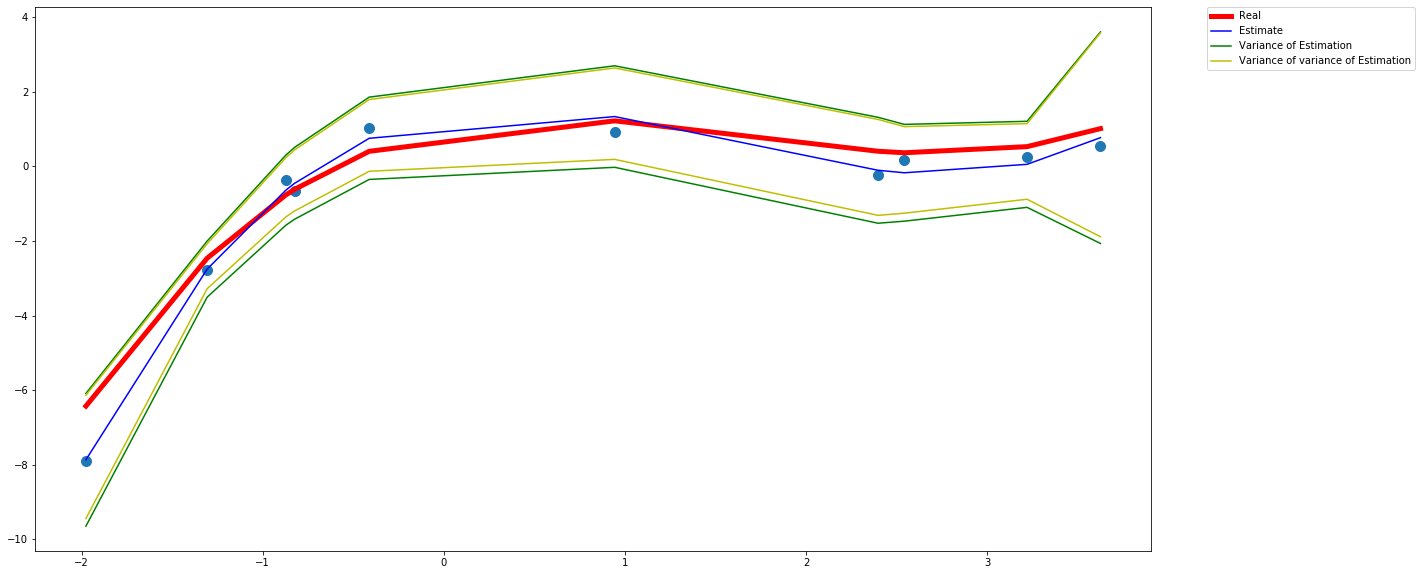

In [251]:
SAMPLE = 10

x = np.array([rnd.uniform(-2, 4) for i in range(SAMPLE)])
MEAN_EPS = 0 
VAR_EPS = 0.6
eps = rnd.normal(MEAN_EPS, VAR_EPS, SAMPLE)

sigma_s = np.var(x)

x.sort()
y = f(x) + eps

cannonical_info = get_initial_cannonical_info(x[0], y[0])
for xi, yi in zip(x, y):
    cannonical_info = update_canonical_info(cannonical_info, xi, yi)
    
draw(plt, cannonical_info, x, y, sigma_s)

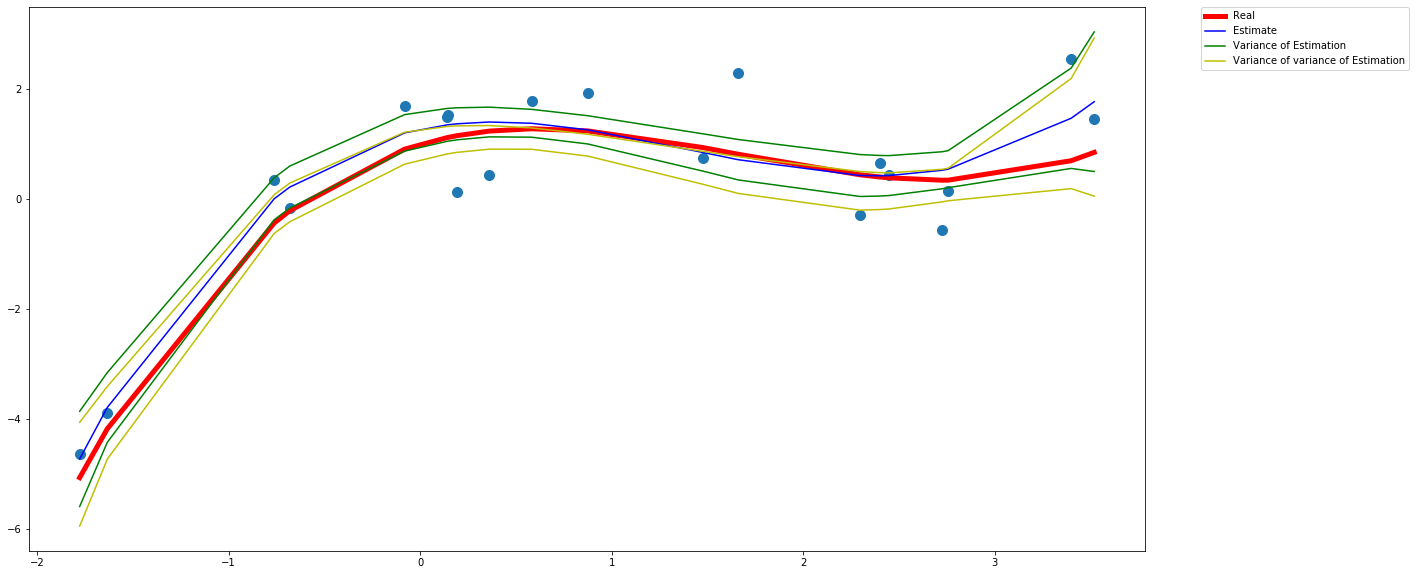

In [252]:
SAMPLE = 20

x = np.array([rnd.uniform(-2, 4) for i in range(SAMPLE)])
MEAN_EPS = 0 
VAR_EPS = 0.6
eps = rnd.normal(MEAN_EPS, VAR_EPS, SAMPLE)

sigma_s = np.var(x)

x.sort()
y = f(x) + eps

cannonical_info = get_initial_cannonical_info(x[0], y[0])
for xi, yi in zip(x, y):
    cannonical_info = update_canonical_info(cannonical_info, xi, yi)
    
draw(plt, cannonical_info, x, y, sigma_s)

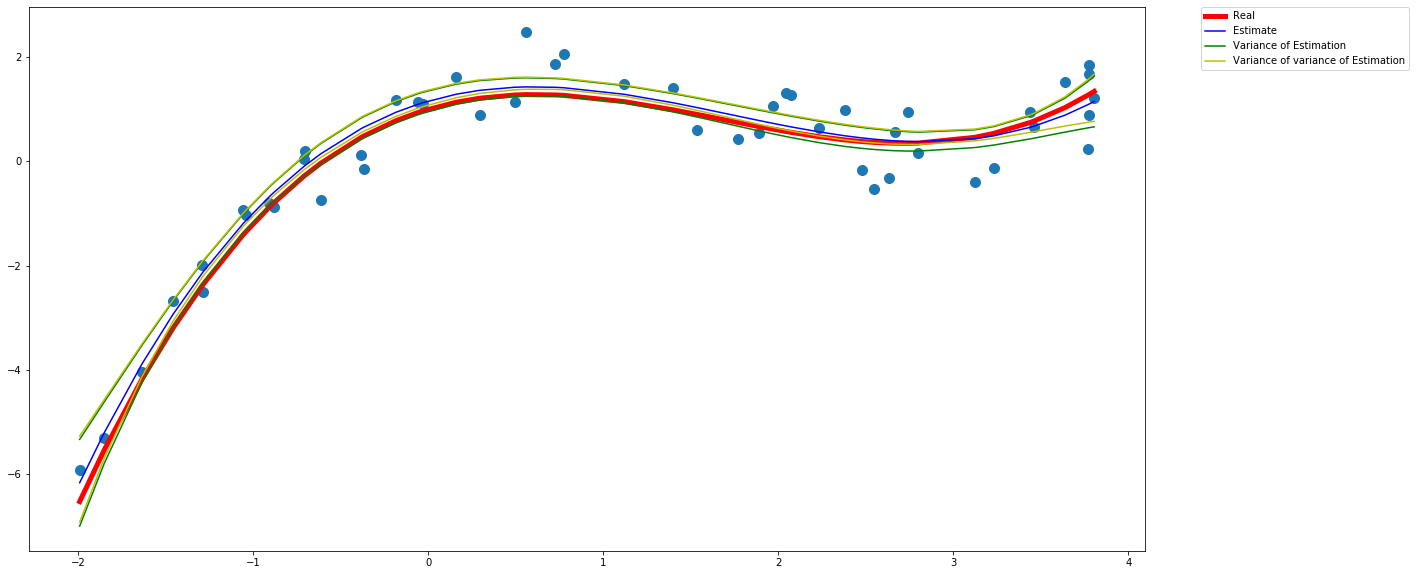

In [253]:
SAMPLE = 50

x = np.array([rnd.uniform(-2, 4) for i in range(SAMPLE)])
MEAN_EPS = 0 
VAR_EPS = 0.6
eps = rnd.normal(MEAN_EPS, VAR_EPS, SAMPLE)

sigma_s = np.var(x)

x.sort()
y = f(x) + eps

cannonical_info = get_initial_cannonical_info(x[0], y[0])
for xi, yi in zip(x, y):
    cannonical_info = update_canonical_info(cannonical_info, xi, yi)
    
draw(plt, cannonical_info, x, y, sigma_s)

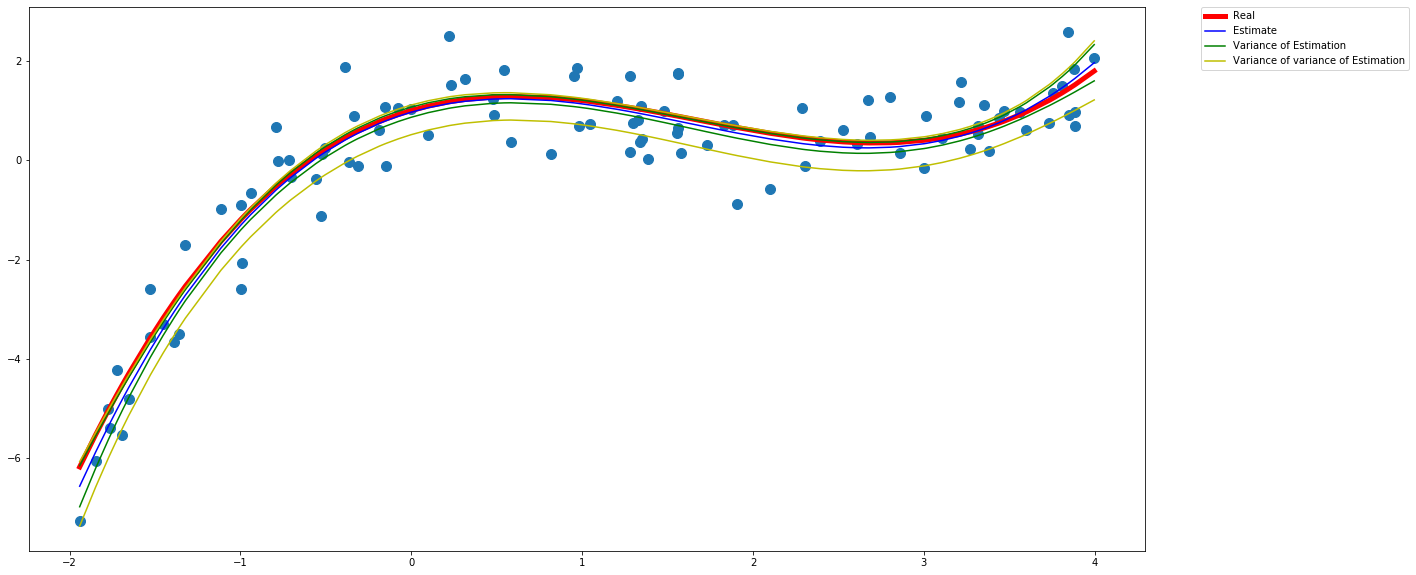

In [254]:
SAMPLE = 100

x = np.array([rnd.uniform(-2, 4) for i in range(SAMPLE)])
MEAN_EPS = 0 
VAR_EPS = 0.6
eps = rnd.normal(MEAN_EPS, VAR_EPS, SAMPLE)

sigma_s = np.var(x)

x.sort()
y = f(x) + eps

cannonical_info = get_initial_cannonical_info(x[0], y[0])
for xi, yi in zip(x, y):
    cannonical_info = update_canonical_info(cannonical_info, xi, yi)
    
draw(plt, cannonical_info, x, y, sigma_s)

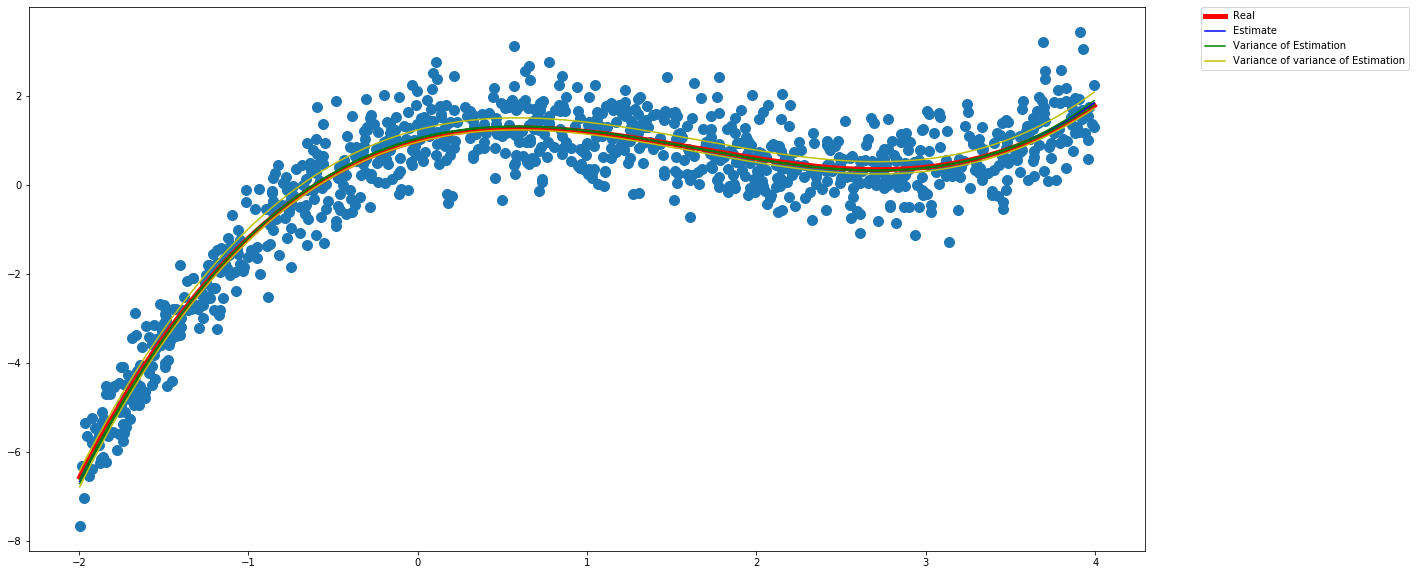

In [255]:
SAMPLE = 1000

x = np.array([rnd.uniform(-2, 4) for i in range(SAMPLE)])
MEAN_EPS = 0 
VAR_EPS = 0.6
eps = rnd.normal(MEAN_EPS, VAR_EPS, SAMPLE)

sigma_s = np.var(x)

x.sort()
y = f(x) + eps

cannonical_info = get_initial_cannonical_info(x[0], y[0])
for xi, yi in zip(x, y):
    cannonical_info = update_canonical_info(cannonical_info, xi, yi)
    
draw(plt, cannonical_info, x, y, sigma_s)